# Dataset prep

In [17]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [18]:
df = pd.read_table('train_preprocess.tsv.txt', names=['text', 'label'])
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [19]:
df.shape

(11000, 2)

In [20]:
df.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

# Text normalization

In [21]:
import re

def clean(text):
    clean_text = text.lower()
    clean_text = re.sub(r'[^\w\s]', '', clean_text) 
    clean_text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', clean_text)

    return clean_text

In [22]:
df['text_clean'] = df['text'].apply(clean)

neg = df.loc[df['label'] == 'negative'].text_clean.to_list()
pos = df.loc[df['label'] == 'positive'].text_clean.to_list()
net = df.loc[df['label'] == 'neutral'].text_clean.to_list()

neg_ls = df.loc[df['label'] == 'negative'].label.to_list()
pos_ls = df.loc[df['label'] == 'positive'].label.to_list()
net_ls = df.loc[df['label'] == 'neutral'].label.to_list()

total_data = neg + pos + net
labels = neg_ls + pos_ls + net_ls

In [23]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung te...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih...


# Feature extraction

In [24]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

In [25]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('tokenizer.pickle has created!')

tokenizer.pickle has created!


In [26]:
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index) 
maxlean = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle' , 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('x_pad_sequences.pickle has created')

x_pad_sequences.pickle has created


In [27]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels.pickle has created!')

y_labels.pickle has created!


# Data split

In [28]:
from sklearn.model_selection import train_test_split
file = open('x_pad_sequences.pickle' , 'rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle', 'rb')   
Y = pickle.load(file)
file.close()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


# Model Training

In [29]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 91, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 35s 40ms/step - loss: 0.4558 - accuracy: 0.8166 - val_loss: 0.3370 - val_accuracy: 0.8736
Epoch 2/10
880/880 [==============================] - 38s 43ms/step - loss: 0.1927 - accuracy: 0.9302 - val_loss: 0.3576 - val_accuracy: 0.8718
Epoch 2: early stopping


# Evaluation

In [30]:
from sklearn import metrics

In [31]:
predictions = model.predict(x_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)


69/69 [==============================] - 1s 7ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       704
           1       0.85      0.75      0.80       219
           2       0.89      0.93      0.91      1277

    accuracy                           0.87      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200



# Cross-validation

In [32]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(x_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print('Training ke-', iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('======================================')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Rata-rata Accuracy: ', average_accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 100)           10000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 34s 38ms/step - loss: 0.4607 - accuracy: 0.8160 - val_loss: 0.3517 - val_accuracy: 0.8595
Epoch 2/10
880/880 [==============================] - 32s 36ms/step - loss: 0.2003 - accuracy: 0.9269 - val_loss: 0.3645 - val_accuracy: 0.8695
Epoch 2: early stopping
69/69 [==============================] - 1s 7ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       704
           1       0.81      0.79      0.80       219
           2       0.87      0.96      0.91      1277

    accuracy                           0.87      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 91, 100)           10000000  
              

None
Epoch 1/10
880/880 [==============================] - 32s 36ms/step - loss: 0.4525 - accuracy: 0.8209 - val_loss: 0.3429 - val_accuracy: 0.8755
Epoch 2/10
880/880 [==============================] - 32s 36ms/step - loss: 0.1964 - accuracy: 0.9301 - val_loss: 0.4002 - val_accuracy: 0.8518
Epoch 2: early stopping
69/69 [==============================] - 1s 7ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       704
           1       0.72      0.83      0.77       219
           2       0.89      0.91      0.90      1277

    accuracy                           0.85      2200
   macro avg       0.81      0.83      0.82      2200
weighted avg       0.85      0.85      0.85      2200

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 91, 100)           10000000  
              

None
Epoch 1/10
880/880 [==============================] - 32s 36ms/step - loss: 0.4644 - accuracy: 0.8195 - val_loss: 0.3575 - val_accuracy: 0.8645
Epoch 2/10
880/880 [==============================] - 31s 36ms/step - loss: 0.2008 - accuracy: 0.9275 - val_loss: 0.3692 - val_accuracy: 0.8650
Epoch 2: early stopping
69/69 [==============================] - 1s 7ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       704
           1       0.87      0.74      0.80       219
           2       0.88      0.93      0.91      1277

    accuracy                           0.86      2200
   macro avg       0.86      0.82      0.84      2200
weighted avg       0.86      0.86      0.86      2200

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 91, 100)           10000000  
              

None
Epoch 1/10
880/880 [==============================] - 32s 36ms/step - loss: 0.4610 - accuracy: 0.8248 - val_loss: 0.3416 - val_accuracy: 0.8768
Epoch 2/10
880/880 [==============================] - 31s 36ms/step - loss: 0.1932 - accuracy: 0.9267 - val_loss: 0.3620 - val_accuracy: 0.8759
Epoch 2: early stopping
69/69 [==============================] - 1s 7ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       704
           1       0.78      0.84      0.81       219
           2       0.92      0.91      0.91      1277

    accuracy                           0.88      2200
   macro avg       0.84      0.86      0.85      2200
weighted avg       0.88      0.88      0.88      2200

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 91, 100)           10000000  
              

None
Epoch 1/10
880/880 [==============================] - 32s 36ms/step - loss: 0.4429 - accuracy: 0.8231 - val_loss: 0.3447 - val_accuracy: 0.8718
Epoch 2/10
880/880 [==============================] - 32s 36ms/step - loss: 0.1927 - accuracy: 0.9291 - val_loss: 0.3781 - val_accuracy: 0.8573
Epoch 2: early stopping
69/69 [==============================] - 1s 7ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       704
           1       0.82      0.78      0.80       219
           2       0.88      0.92      0.90      1277

    accuracy                           0.86      2200
   macro avg       0.84      0.82      0.83      2200
weighted avg       0.86      0.86      0.86      2200




Rata-rata Accuracy:  0.8639090909090908


In [33]:
model.save('model.h5')
print('model has created!')

model has created!


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualization

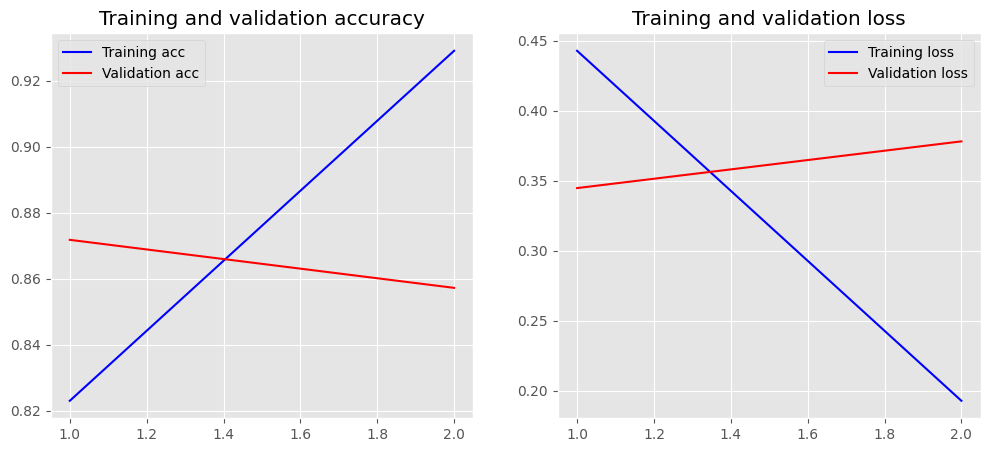

In [34]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


%matplotlib inline
plot_history(history)

# Model prediction

In [35]:
import re
from keras.models import load_model

input_text = """"
apasih lu, gak usah ganggu gua lagi
"""

In [36]:
sentiment = ['negative','neutral', 'positive']
text = [clean(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ', text[0])
print('Sentiment: ', sentiment[polarity])

1/1 [==============================] - 0s 139ms/step
Text:   apasih lu gak usah ganggu gua lagi 
Sentiment:  negative


# Predict new data

In [38]:
df_predict = pd.read_csv("data.csv", encoding='latin-1')
df_predict['cleaned_tweet'] = df_predict['Tweet'].apply(clean)

In [39]:
sentiment_type = ['negative','neutral', 'positive']
text = df_predict['cleaned_tweet'].to_list()
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction)

412/412 [==============================] - 3s 8ms/step


In [40]:
prediction.shape

(13169, 3)

In [41]:
sentiment_result = []
for i in range(prediction.shape[0]):
    sentiment = sentiment_type[np.argmax(prediction[i])]
    sentiment_result.append(sentiment) 

In [63]:
df_predict['sentiment'] = sentiment_result
df_predict

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,cleaned_tweet,sentiment
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,disaat semua cowok berusaha melacak perhatian...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,rt user user siapa yang telat ngasih tau elued...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berfikir kenapa aku tetap percay...,positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,user user aku itu akunnku tau matamu sipit tap...,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,user user kaum cebong kapir udah keliatan dong...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0,user jangan asal ngomong ndasmu congor lu yg s...,negative
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0,user kasur mana enak kunyuk,negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0,user hati hati bisu gnnlagi bosan huft xf0x9f...,positive
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0,user user user user bom yang real mudah terdet...,positive


# Store result in DB

In [42]:
import sqlite3
conn = sqlite3.connect('sentiment_predictions.db')
df_predict.to_sql('sentiment_predictions', con=conn, index=False, if_exists='replace')

# Tutup koneksi setelah selesai
conn.close()